# Example: Slicing and sampling

In this example we use the neuroscience concepts of slicing and sampling.
In a more general sense, this combines two biologically inspired techniques of generating samples of sub-populations of a spatially embedded network. The first samples anything in a rectangular box (i.e. a slice) and generates additional coordinates that are axis-aligned with the box. The second generates a random sample of a specified size with a spatial bias that is inspired by "patch-clamp" sampling.

We begin by loading data. In this example, we load neuron-to-neuron connectivity of a few thousand neurons in a biologically detailed model. It also loads a list of "properties" associated with the nodes (neurons), such as their locations in two different coordinate systems.

We demonstrate how the data would be loaded from a circuit model in Sonata format, but in case you don't have a Sonata circuit available, there is also a serialized version provided with this repository.

In [1]:
import numpy, pandas
import bluepy
import conntility
import os

from scipy.spatial import distance
from matplotlib import pyplot as plt


# Describes which node properties to load and filtering based on them
# This loads a small subvolume of aorund 6.5k nodes
load_cfg = {
    "loading":{    
        "properties": ["x", "y", "z", "mtype", "layer", "synapse_class", "ss_flat_x", "ss_flat_y", "depth"]
    },
    "filtering":[
        {
            "column": "synapse_class",
            "values": ["EXC"]
        },
        {
            "column": "layer",
            "values": [2, 3]
        },
        {
            "column": "ss_flat_x",
            "interval": [2000, 2400]
        },
        {
            "column": "ss_flat_y",
            "interval": [2000, 2400]
        }
    ]
}

# Some additional configuration
fn_circ = "/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_TC_WM"
fn_con_mat = "L23_EXC_sampled_cmat.h5"
columns_slice=["ss_flat_x", "ss_flat_y"]
column_y = "depth"
population = "default"

# Since you may not have access to the Sonata circuit this example is based on, we provide the result also in hdf5
if os.path.exists(fn_con_mat):
    cmat = conntility.ConnectivityMatrix.from_h5(fn_con_mat)
else:
    circ = bluepy.Circuit(fn_circ)
    cmat = conntility.ConnectivityMatrix.from_bluepy(circ, load_config=load_cfg, population=population)
    cmat.to_h5(fn_con_mat)

We loaded the population of EXC neurons in layers L2 and L3, as well as the connectivity between them.
This is how the information is accessed. As an example, we plot locations of nodes.

Note how the locations are within an axis aligned box. This is because we filtered out anything outside the box in the "load config". 


    gid  layer     mtype synapse_class            x            y            z  \
0  8647      3  L3_TPC:A           EXC  4987.491857 -1248.527732 -2652.220390   
1  8902      3  L3_TPC:A           EXC  5007.159338 -1414.930054 -2601.008390   
2  8926      3  L3_TPC:A           EXC  4949.038391 -1233.970590 -2853.754694   
3  9059      3  L3_TPC:A           EXC  4816.936883 -1048.781999 -2439.590046   
4  9446      3  L3_TPC:A           EXC  4993.319550 -1317.183372 -2743.336355   

     ss_flat_x       depth    ss_flat_y  
0  2224.790835  399.050115  2169.890329  
1  2128.170473  328.612557  2047.922547  
2  2314.389681  497.596932  2098.078740  
3  2162.378981  433.084110  2399.301808  
4  2230.874732  442.740524  2084.533891  


<6744x6744 sparse matrix of type '<class 'numpy.bool_'>'
	with 755427 stored elements in COOrdinate format>

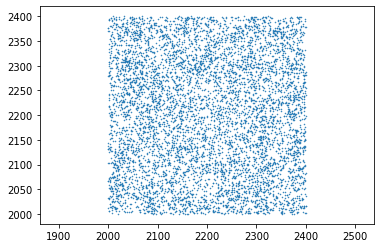

In [3]:
# Neuron information
print(cmat.vertices.head())
plt.plot(cmat.vertices["ss_flat_x"], cmat.vertices["ss_flat_y"], '.', ms=1)
_ = plt.axis("equal")

# Matrix of connections between neurons in this population
cmat.matrix

Now we first generate a slice of the population.
That is, the population of nodes will be subsampled to the ones inside a box with specified geometry.
The first argument is the angle of the box in the plane defined by the "columns_slice".
The second is the offset, orthogonal to that angle in the same plane. An offset of 0 will place the box at the very center.
column_y is specifies the third coordinate. The sample will span all values of that coordinate, but a copy of it will be provided as a local slice coordinate for convenience.

(1980.0284809877346,
 2419.8742434335236,
 1980.1681961549743,
 2419.9746529753156)

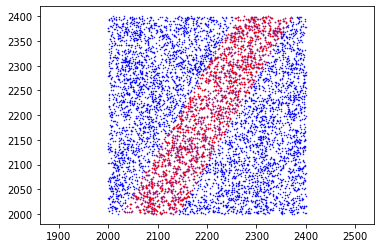

In [4]:
c_slice = cmat.slice(numpy.pi / 3., # Angle at which the slice is taken. Here, intentially very "diagonal"
                     0, # Offset of the slice from the center of the population
                     100.0, # Thickness in um
                     columns_slice=columns_slice, 
                     column_y=column_y)

plt.plot(cmat.vertices["ss_flat_x"], cmat.vertices["ss_flat_y"], '.b', ms=1)  # Full population
plt.plot(c_slice.vertices["ss_flat_x"], c_slice.vertices["ss_flat_y"], '.r', ms=1)  # Slice population in red
plt.axis("equal")

The slice also defines its own coordinate system. "slice_x" lies in the plane defined by "columns_slice" and is parallel to the direction defined by the angle. "slice_y" is a copy of "column_y".

In the neuroscience context they are the horizontal and vertical coordinate of the slice.

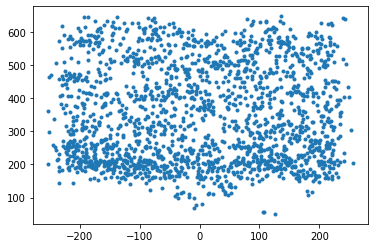

In [13]:
plt.plot(c_slice.vertices["slice_x"], c_slice.vertices["slice_y"], '.')

In the slice, we can now do patch experiments. 
That is, we generate random subsamples with a spatial bias in the two slice coordinates.

The bias of the patch sample are defined by two parameters:
"mv_cv" is the covariance matrix of a multivariate gaussian that defines the extent of the area within which the experimenter is assumed to sample.  
In this example, we keep off-diagonal entries 0 (no dependence between the two coordinates), but give one a larger diagonal entry (sampling a larger extent along the vertical axis). 

The other parameter is the number of nodes to sample.

Each call of the function will generate a random sample of patched cells with the defined statistics. 

In [14]:
from scipy import stats

n_patch = 4
mv_cv = numpy.array([[1000, 0],  # extent in slice x coordinates
                     [0, 2000]])  # and in slice y (vertical)

patch_sample = c_slice.patch_sample(n_patch, [0, 0], mv_cv, columns_xy=["slice_x", "slice_y"])

print(patch_sample.vertices)  # Neurons that were samples
print(patch_sample.array)  # connectivity array

    index  layer     mtype synapse_class            x            y  \
0  358282      3  L3_TPC:A           EXC  4926.486789 -1104.262386   
1  564910      3  L3_TPC:C           EXC  4862.769002 -1148.732655   
2  103455      3  L3_TPC:A           EXC  4902.003804 -1140.243204   
3  249507      3  L3_TPC:A           EXC  4877.472519 -1137.063862   

             z    ss_flat_x       depth    ss_flat_y     slice_x     slice_y  \
0 -2645.595645  2238.668954  474.797127  2311.320222  115.096211  474.797127   
1 -2670.790252  2248.544369  513.186479  2229.186159   48.903733  513.186479   
2 -2605.545737  2242.423353  460.363129  2254.087407   67.408339  460.363129   
3 -2680.956823  2247.328724  511.017065  2250.388262   66.657471  511.017065   

   slice_depth  
0    21.632113  
1   -27.987278  
2   -10.235699  
3   -16.333448  
[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]


We use this to generate many samples and gather connectivity statistics.
This approximates the way connection probabilities are estimated in slices of neural tissue.


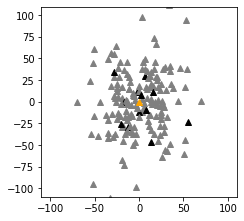

In [19]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.gca()
plot = True
yaxis_orientation_depth = -1 # This flips the direction of the vertical axis when plotting. Purely visual.

stats_D = []
stats_M = []
stats_A = []

# Number of nodes per random sample and number of samples
n_samples = 14
n_patched = 4

for _ in range(n_samples):
    smpl = c_slice.patch_sample(n_patched, [0., 0.], mv_cv, columns_xy=["slice_x", "slice_y"])
    smpl_coords = smpl.vertices[["slice_x", "slice_y"]]
    if yaxis_orientation_depth == 1:
        A = smpl_coords.values.reshape((1, n_patched, 2)) - smpl_coords.values.reshape((n_patched, 1, 2))
    else:
        A = smpl_coords.values.reshape((n_patched, 1, 2)) - smpl_coords.values.reshape((1, n_patched, 2))
    M = smpl.array
    for pt, c in zip(A.reshape((-1, 2)), M.reshape((-1,))):
        if numpy.abs(pt).sum() > 0 and plot:
            if c:
                ax.plot(*pt, '^', color="black")
            else:
                ax.plot(*pt, '^', color='grey')
    
    stats_D.append(numpy.sqrt((A ** 2).sum(axis=2)).flatten())  # Distances of sampled pairs
    stats_A.append(numpy.sign(A[:, :, 1]).flatten())  # For each pair: Was the presyn. neuron above?
    stats_M.append(M.flatten())  # Presence of connection for each pair

ax.plot(0, 0, '^', color="orange")
ax.set_xlim([-110, 110])
ax.set_ylim([-110, 110])

stats_D = numpy.hstack(stats_D)
stats_A = numpy.hstack(stats_A)
stats_M = numpy.hstack(stats_M)

Plot aggregate statistics

Text(0, 0.5, 'Connection probability')

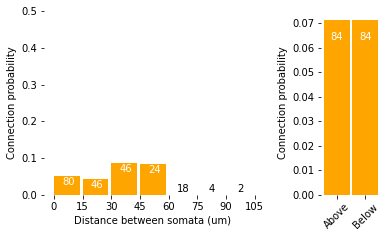

In [22]:
orientation_bins = [1, -1]
dbins = [0, 15, 30, 45, 60, 75, 90, 105]
stats_bins = numpy.digitize(stats_D, bins=dbins)
mnM_d = [numpy.mean(stats_M[stats_bins == i]) for i in range(1, len(dbins))]
counts_d = numpy.histogram(stats_D, bins=dbins)[0]
mnM_a = [numpy.mean(stats_M[stats_A == i]) for i in orientation_bins]
counts_a = [numpy.sum(stats_A == i) for i in orientation_bins]

fig = plt.figure(figsize=(5.5, 3.))
ax = fig.add_axes([0.1, 0.1, 0.55, 0.85])
col = "orange"

ax.bar(dbins[:-1], mnM_d, color=col, width=0.9*numpy.mean(numpy.diff(dbins)), align="edge")
for i, y in enumerate(mnM_d):
    x = 0.5 * (dbins[i] + dbins[i + 1])
    v = counts_d[i]
    if y > 0:
        ax.text(x, y-0.002, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
ax.set_xticks(dbins)
ax.set_frame_on(False)
ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")
ax.set_xlabel("Distance between somata (um)")

ax = fig.add_axes([0.8, 0.1, 0.15, 0.85])

ax.bar([0, 1], mnM_a, color=col, width=0.9)
for i, y in enumerate(mnM_a):
    x = i
    v = counts_a[i]
    if y > 0:
        ax.text(x, y-0.005, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
    ax.set_xticks([0, 1]); ax.set_xticklabels(["Above", "Below"], rotation=45.)
ax.set_frame_on(False)
#ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")

We can also calculate the "actual" values, i.e. calculated for all pairs. Not just randomly sampled.

Text(0, 0.5, 'Connection probability')

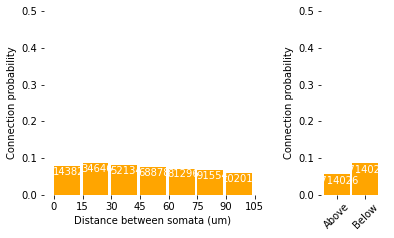

In [23]:
D = distance.squareform(distance.pdist(c_slice.vertices[["slice_x", "slice_y"]]))
O = c_slice.vertices["slice_y"].values.reshape((-1, 1)) - c_slice.vertices["slice_y"].values.reshape((1, -1))

Dbins = numpy.digitize(D, bins=dbins)
M = c_slice.dense_matrix

p_in_bins = numpy.array([
    M[Dbins == i].mean() for i in range(1, len(dbins))
])
p_for_orientation = numpy.array([
    M[(O > 0) & (D < dbins[-1])].mean(), M[(O < 0) & (D < dbins[-1])].mean()  # Sample all pairs, but within the same distance
])
count_in_bins = numpy.histogram(D, bins=dbins)[0]
count_for_orientation = numpy.array([(O > 0).sum(), (O < 0).sum()])


fig = plt.figure(figsize=(5.5, 3.))
ax = fig.add_axes([0.1, 0.1, 0.55, 0.85])
col = "orange"

ax.bar(dbins[:-1], p_in_bins, color=col, width=0.9*numpy.mean(numpy.diff(dbins)), align="edge")
for i, y in enumerate(p_in_bins):
    x = 0.5 * (dbins[i] + dbins[i + 1])
    v = count_in_bins[i]
    if y > 0:
        ax.text(x, y-0.002, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
ax.set_xticks(dbins)
ax.set_frame_on(False)
ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")
ax.set_xlabel("Distance between somata (um)")

ax = fig.add_axes([0.8, 0.1, 0.15, 0.85])

ax.bar([0, 1], p_for_orientation, color=col, width=0.9)
for i, y in enumerate(p_for_orientation):
    x = i
    v = count_for_orientation[i]
    if y > 0:
        ax.text(x, y-0.005, "{0}".format(v), color="white", horizontalalignment="center", verticalalignment="top")
    else:
        ax.text(x, y+0.001, "{0}".format(v), color="black", horizontalalignment="center", verticalalignment="bottom")
    ax.set_xticks([0, 1]); ax.set_xticklabels(["Above", "Below"], rotation=45.)
ax.set_frame_on(False)
ax.set_ylim([0, 0.5])
ax.set_ylabel("Connection probability")